<a href="https://colab.research.google.com/github/hila-chefer/RobustViT/blob/master/RobustViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hila-chefer/RobustViT.git

import os
os.chdir(f'./RobustViT')

Cloning into 'RobustViT'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 148 (delta 59), reused 87 (delta 19), pack-reused 0
Receiving objects: 100% (148/148), 8.11 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
!pip install timm
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from CLS2IDX import CLS2IDX

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])
transform_224 = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

In [4]:
#@title Downloading finetuned models (may take a few minutes)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads weights
ids = ['1jbWiuBrL4sKpAjG3x4oGbs3WOC2UdbIb', '1DHKX_s8rVCDiX4pwnuCCZdGWsOl4SFMn', '1vDmuvbdLbYVAqWz6yVM4vT1Wdzt8KV-g']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [6]:
model_name = 'augreg_base' #@param ['augreg_base','vit_base', 'deit_base']

if model_name == 'augreg_base':
  from ViT.ViT_new import vit_base_patch16_224 as vit

  # initialize ViT pretrained
  model = vit(pretrained=True).cuda()
  model.eval()

  model_finetuned = vit().cuda()
  checkpoint = torch.load('ar_base.tar')

if model_name == 'vit_base':
  from ViT.ViT import vit_base_patch16_224 as vit

  # initialize ViT pretrained
  model = vit(pretrained=True).cuda()
  model.eval()

  model_finetuned = vit().cuda()
  checkpoint = torch.load('vit_base.tar')

if model_name == 'deit_base':
  from ViT.ViT import deit_base_patch16_224 as vit

  # initialize ViT pretrained
  model = vit(pretrained=True).cuda()
  model.eval()

  model_finetuned = vit().cuda()
  checkpoint = torch.load('deit_base.tar')

model_finetuned.load_state_dict(checkpoint['state_dict'])
model_finetuned.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

In [7]:
start_layer = 0

# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input, register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for i,blk in enumerate(model.blocks):
        if i < start_layer:
            continue
        grad = blk.attn.get_attn_gradients()
        cam = blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    return R[0, 1:]

In [8]:
def generate_visualization(model, original_image, class_index=None):
    with torch.enable_grad():
        transformer_attribution = generate_relevance(model, original_image.unsqueeze(0).cuda(), index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

# ImageNet-A

original model
Top 5 classes:
	829 : streetcar, tram, tramcar, trolley, trolley car		value = 10.911	 prob = 57.2%
	874 : trolleybus, trolley coach, trackless trolley  		value = 10.221	 prob = 28.7%
	466 : bullet train, bullet                          		value = 6.897	 prob = 1.0%
	733 : pole                                          		value = 6.878	 prob = 1.0%
	547 : electric locomotive                           		value = 6.626	 prob = 0.8%
finetuned model
Top 5 classes:
	847 : tank, army tank, armored combat vehicle, armoured combat vehicle		value = 11.573	 prob = 60.1%
	408 : amphibian, amphibious vehicle                                   		value = 10.085	 prob = 13.6%
	874 : trolleybus, trolley coach, trackless trolley                    		value = 9.585	 prob = 8.2%
	829 : streetcar, tram, tramcar, trolley, trolley car                  		value = 9.583	 prob = 8.2%
	586 : half track                                                      		value = 7.935	 prob = 1.6%


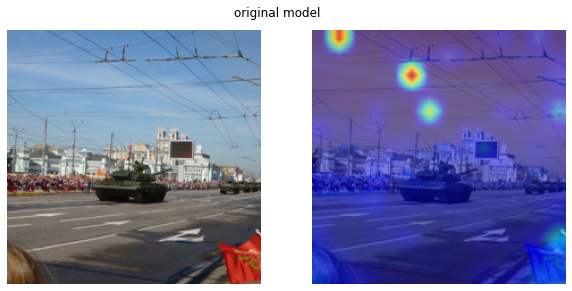

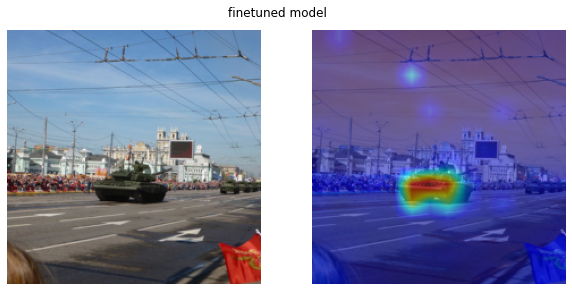

In [9]:
with torch.no_grad():
    image = Image.open(f'samples/{model_name}/a.png')
    dog_cat_image = transform_224(image)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_cat_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    out = generate_visualization(model, dog_cat_image)

    fig.suptitle('original model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(dog_cat_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    out = generate_visualization(model_finetuned, dog_cat_image)

    fig.suptitle('finetuned model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

original model
Top 5 classes:
	59 : vine snake                                                                                                               		value = 7.554	 prob = 10.2%
	319 : dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk		value = 7.157	 prob = 6.9%
	41 : whiptail, whiptail lizard                                                                                                		value = 6.853	 prob = 5.1%
	320 : damselfly                                                                                                                		value = 6.687	 prob = 4.3%
	58 : water snake                                                                                                              		value = 6.560	 prob = 3.8%
finetuned model
Top 5 classes:
	94 : hummingbird                                                                                                              		value = 12.102	 prob = 85.8

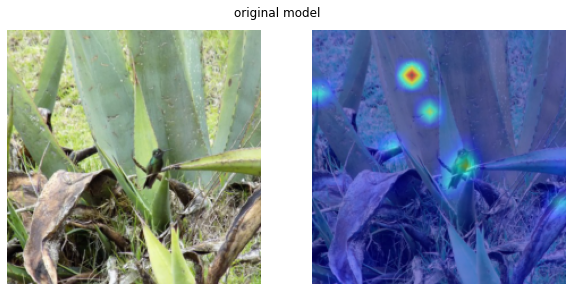

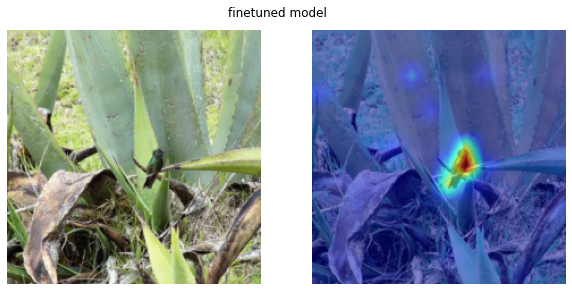

In [10]:
with torch.no_grad():
    image = Image.open(f'samples/{model_name}/a_2.png')
    dog_cat_image = transform_224(image)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_cat_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    out = generate_visualization(model, dog_cat_image)

    fig.suptitle('original model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(dog_cat_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    out = generate_visualization(model_finetuned, dog_cat_image)

    fig.suptitle('finetuned model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

original model
Top 5 classes:
	95 : jacamar          		value = 10.054	 prob = 35.7%
	94 : hummingbird      		value = 8.942	 prob = 11.7%
	16 : bulbul           		value = 8.786	 prob = 10.0%
	91 : coucal           		value = 8.424	 prob = 7.0%
	380 : titi, titi monkey		value = 7.311	 prob = 2.3%
finetuned model
Top 5 classes:
	94 : hummingbird                                   		value = 12.747	 prob = 69.9%
	95 : jacamar                                       		value = 11.568	 prob = 21.5%
	91 : coucal                                        		value = 9.446	 prob = 2.6%
	16 : bulbul                                        		value = 8.384	 prob = 0.9%
	40 : American chameleon, anole, Anolis carolinensis		value = 7.679	 prob = 0.4%


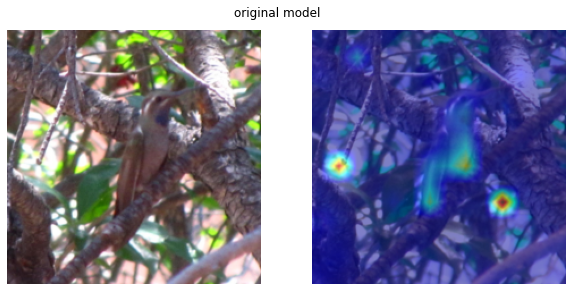

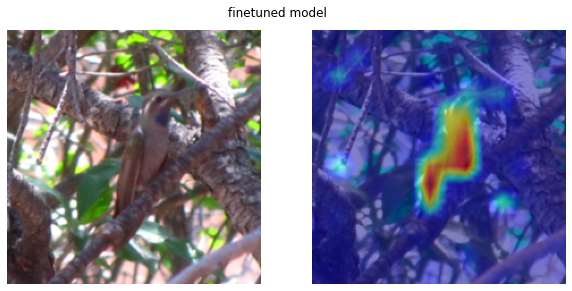

In [11]:
with torch.no_grad():
    image = Image.open(f'samples/{model_name}/a_3.png')
    dog_cat_image = transform_224(image)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_cat_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    out = generate_visualization(model, dog_cat_image)

    fig.suptitle('original model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(dog_cat_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    out = generate_visualization(model_finetuned, dog_cat_image)

    fig.suptitle('finetuned model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

#ImageNet-val (examples of improved explainability)

original model
Top 5 classes:
	835 : sundial                       		value = 16.945	 prob = 100.0%
	635 : magnetic compass              		value = 7.289	 prob = 0.0%
	458 : brass, memorial tablet, plaque		value = 6.976	 prob = 0.0%
	708 : pedestal, plinth, footstall   		value = 6.631	 prob = 0.0%
	640 : manhole cover                 		value = 6.186	 prob = 0.0%
finetuned model
Top 5 classes:
	835 : sundial                       		value = 18.044	 prob = 100.0%
	635 : magnetic compass              		value = 7.752	 prob = 0.0%
	640 : manhole cover                 		value = 7.569	 prob = 0.0%
	458 : brass, memorial tablet, plaque		value = 7.307	 prob = 0.0%
	892 : wall clock                    		value = 6.690	 prob = 0.0%


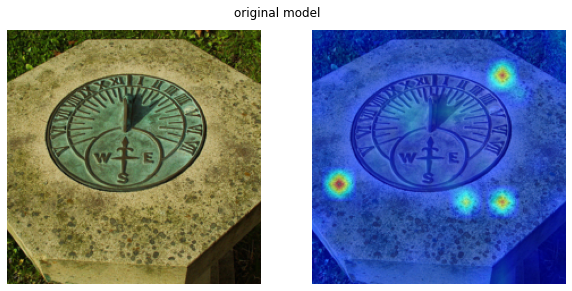

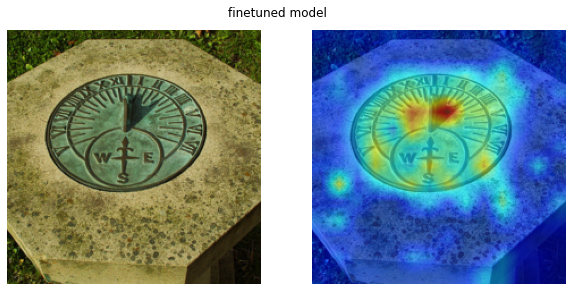

In [12]:
with torch.no_grad():
    image = Image.open(f'samples/{model_name}/1_in.png')
    dog_cat_image = transform_224(image)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_cat_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    out = generate_visualization(model, dog_cat_image)

    fig.suptitle('original model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(dog_cat_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    out = generate_visualization(model_finetuned, dog_cat_image)

    fig.suptitle('finetuned model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

original model
Top 5 classes:
	128 : black stork, Ciconia nigra             		value = 13.614	 prob = 98.1%
	127 : white stork, Ciconia ciconia           		value = 8.363	 prob = 0.5%
	134 : crane                                  		value = 8.030	 prob = 0.4%
	135 : limpkin, Aramus pictus                 		value = 6.888	 prob = 0.1%
	136 : European gallinule, Porphyrio porphyrio		value = 6.623	 prob = 0.1%
finetuned model
Top 5 classes:
	128 : black stork, Ciconia nigra             		value = 14.663	 prob = 99.1%
	127 : white stork, Ciconia ciconia           		value = 8.785	 prob = 0.3%
	134 : crane                                  		value = 8.022	 prob = 0.1%
	136 : European gallinule, Porphyrio porphyrio		value = 7.559	 prob = 0.1%
	135 : limpkin, Aramus pictus                 		value = 7.169	 prob = 0.1%


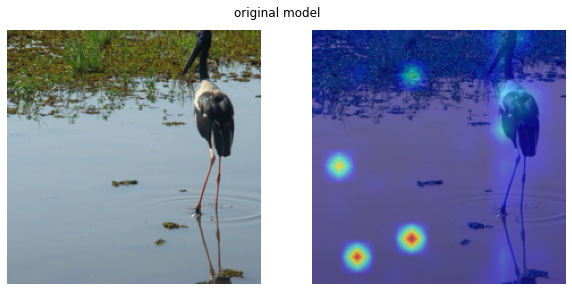

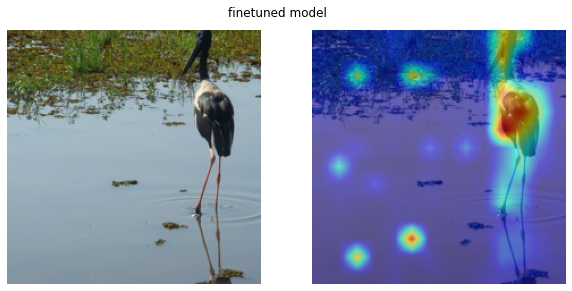

In [13]:
with torch.no_grad():
    image = Image.open(f'samples/{model_name}/2_in.png')
    dog_cat_image = transform_224(image)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_cat_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    out = generate_visualization(model, dog_cat_image)

    fig.suptitle('original model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(dog_cat_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    out = generate_visualization(model_finetuned, dog_cat_image)

    fig.suptitle('finetuned model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

original model
Top 5 classes:
	46 : green lizard, Lacerta viridis                 		value = 15.318	 prob = 70.7%
	40 : American chameleon, anole, Anolis carolinensis		value = 14.431	 prob = 29.1%
	44 : alligator lizard                              		value = 8.521	 prob = 0.1%
	38 : banded gecko                                  		value = 7.617	 prob = 0.0%
	39 : common iguana, iguana, Iguana iguana          		value = 7.359	 prob = 0.0%
finetuned model
Top 5 classes:
	46 : green lizard, Lacerta viridis                 		value = 16.743	 prob = 69.6%
	40 : American chameleon, anole, Anolis carolinensis		value = 15.908	 prob = 30.2%
	44 : alligator lizard                              		value = 9.728	 prob = 0.1%
	38 : banded gecko                                  		value = 9.029	 prob = 0.0%
	39 : common iguana, iguana, Iguana iguana          		value = 8.248	 prob = 0.0%


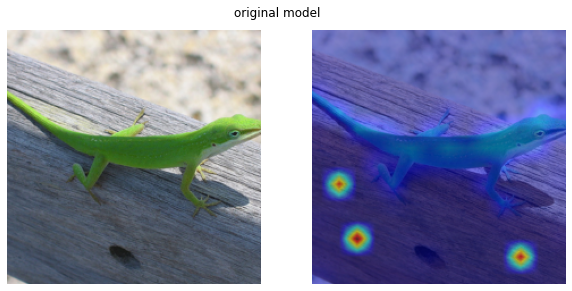

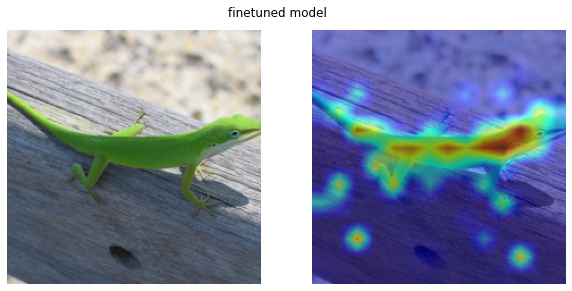

In [14]:
with torch.no_grad():
    image = Image.open(f'samples/{model_name}/3_in.png')
    dog_cat_image = transform_224(image)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_cat_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    out = generate_visualization(model, dog_cat_image)

    fig.suptitle('original model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(dog_cat_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    out = generate_visualization(model_finetuned, dog_cat_image)

    fig.suptitle('finetuned model',y=0.8)
    axs[1].imshow(out);
    axs[1].axis('off');

# Multi-class examples

original model
Top 5 classes:
	243 : bull mastiff    		value = 10.930	 prob = 51.4%
	242 : boxer           		value = 9.742	 prob = 15.7%
	282 : tiger cat       		value = 9.620	 prob = 13.9%
	285 : Egyptian cat    		value = 8.748	 prob = 5.8%
	281 : tabby, tabby cat		value = 7.843	 prob = 2.3%
finetuned model
Top 5 classes:
	243 : bull mastiff  		value = 12.168	 prob = 49.6%
	242 : boxer         		value = 11.954	 prob = 40.1%
	245 : French bulldog		value = 9.369	 prob = 3.0%
	282 : tiger cat     		value = 9.170	 prob = 2.5%
	285 : Egyptian cat  		value = 7.620	 prob = 0.5%


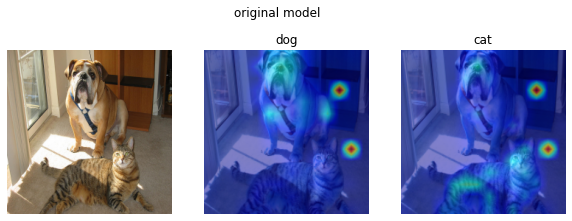

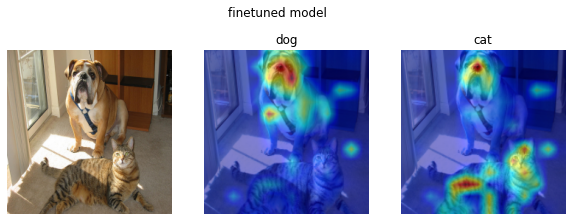

In [15]:
with torch.no_grad():
    image = Image.open('samples/catdog.png')
    dog_cat_image = transform(image)

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_cat_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    dog = generate_visualization(model, dog_cat_image, class_index=243)

    cat = generate_visualization(model, dog_cat_image, class_index=285)

    fig.suptitle('original model',y=0.75)
    axs[1].imshow(dog);
    axs[1].title.set_text('dog');
    axs[1].axis('off');
    axs[2].title.set_text('cat');
    axs[2].imshow(cat);
    axs[2].axis('off');

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(dog_cat_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    # dog
    dog = generate_visualization(model_finetuned, dog_cat_image, class_index=243)

    # cat 
    cat = generate_visualization(model_finetuned, dog_cat_image, class_index=285)

    fig.suptitle('finetuned model',y=0.75)
    axs[1].imshow(dog);
    axs[1].title.set_text('dog');
    axs[1].axis('off');
    axs[2].title.set_text('cat');
    axs[2].imshow(cat);
    axs[2].axis('off');

original model
Top 5 classes:
	340 : zebra                               		value = 12.682	 prob = 53.3%
	386 : African elephant, Loxodonta africana		value = 12.197	 prob = 32.8%
	101 : tusker                              		value = 10.865	 prob = 8.7%
	385 : Indian elephant, Elephas maximus    		value = 9.593	 prob = 2.4%
	351 : hartebeest                          		value = 7.921	 prob = 0.5%
finetuned model
Top 5 classes:
	340 : zebra                               		value = 14.411	 prob = 65.0%
	386 : African elephant, Loxodonta africana		value = 13.612	 prob = 29.2%
	101 : tusker                              		value = 11.559	 prob = 3.8%
	385 : Indian elephant, Elephas maximus    		value = 10.518	 prob = 1.3%
	351 : hartebeest                          		value = 8.033	 prob = 0.1%


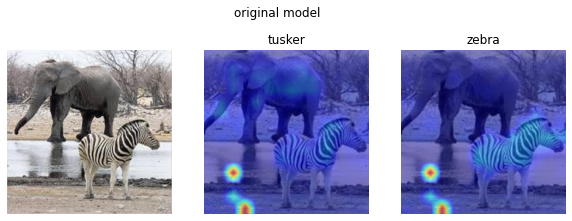

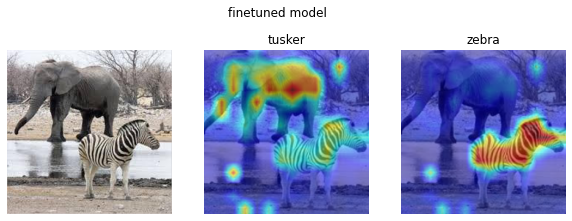

In [16]:
with torch.no_grad():
    image = Image.open('samples/el2.png')
    tusker_zebra_image = transform(image)

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(tusker_zebra_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    # tusker
    tusker = generate_visualization(model,tusker_zebra_image, class_index=101)

    # zebra 
    zebra = generate_visualization(model,tusker_zebra_image, class_index=340)

    fig.suptitle('original model',y=0.75)
    axs[1].imshow(tusker);
    axs[1].title.set_text('tusker');
    axs[1].axis('off');
    axs[2].title.set_text('zebra');
    axs[2].imshow(zebra);
    axs[2].axis('off');


    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');
    output = model_finetuned(tusker_zebra_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    # tusker
    tusker = generate_visualization(model_finetuned,tusker_zebra_image, class_index=101)

    # zebra 
    zebra = generate_visualization(model_finetuned,tusker_zebra_image, class_index=340)

    fig.suptitle('finetuned model',y=0.75)
    axs[1].imshow(tusker);
    axs[1].title.set_text('tusker');
    axs[1].axis('off');
    axs[2].title.set_text('zebra');
    axs[2].imshow(zebra);
    axs[2].axis('off');

original model
Top 5 classes:
	161 : basset, basset hound         		value = 10.174	 prob = 51.3%
	163 : bloodhound, sleuthhound      		value = 9.385	 prob = 23.3%
	166 : Walker hound, Walker foxhound		value = 8.500	 prob = 9.6%
	88 : macaw                        		value = 7.280	 prob = 2.8%
	90 : lorikeet                     		value = 7.249	 prob = 2.8%
finetuned model
Top 5 classes:
	161 : basset, basset hound         		value = 11.515	 prob = 72.9%
	163 : bloodhound, sleuthhound      		value = 9.739	 prob = 12.3%
	166 : Walker hound, Walker foxhound		value = 8.636	 prob = 4.1%
	90 : lorikeet                     		value = 8.420	 prob = 3.3%
	167 : English foxhound             		value = 7.764	 prob = 1.7%


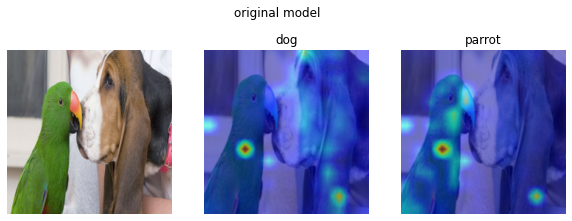

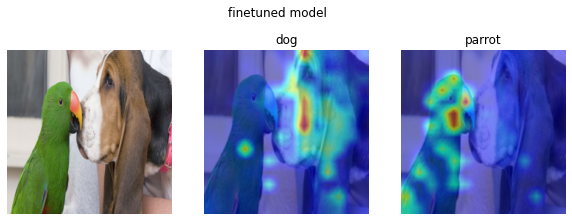

In [17]:
with torch.no_grad():
    image = Image.open('samples/dogbird.png')
    dog_bird_image = transform(image)

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model(dog_bird_image.unsqueeze(0).cuda())
    print("original model")
    print_top_classes(output)

    # basset 
    basset = generate_visualization(model, dog_bird_image, class_index=161)

    # 'African grey, African gray, Psittacus erithacus (grey parrot)'
    parrot = generate_visualization(model, dog_bird_image, class_index=87)

    fig.suptitle('original model',y=0.75)
    axs[1].imshow(basset);
    axs[1].title.set_text('dog');
    axs[1].axis('off');
    axs[2].title.set_text('parrot');
    axs[2].imshow(parrot);
    axs[2].axis('off');


    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(10, 7)
    axs[0].imshow(image);
    axs[0].axis('off');

    output = model_finetuned(dog_bird_image.unsqueeze(0).cuda())
    print("finetuned model")
    print_top_classes(output)

    # basset 
    basset = generate_visualization(model_finetuned, dog_bird_image, class_index=161)

    # 'African grey, African gray, Psittacus erithacus (grey parrot)'
    parrot = generate_visualization(model_finetuned, dog_bird_image, class_index=87)

    fig.suptitle('finetuned model',y=0.75)
    axs[1].imshow(basset);
    axs[1].title.set_text('dog');
    axs[1].axis('off');
    axs[2].title.set_text('parrot');
    axs[2].imshow(parrot);
    axs[2].axis('off');